# Notebook for extended figures in Lakshmikanth et al - Immune system adaptation during female-to-male sex-reassignment

In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import re

import os
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Specify adata_paths here

In [3]:
r848_v1_path = 'data/anndata_folder_scRNAseq/R848V1.h5ad' #
r848_v2_path = 'data/anndata_folder_scRNAseq/R848V2.h5ad'#

ntc_v1_path = 'data/anndata_folder_scRNAseq/NTCV1.h5ad'#
ntc_v2_path = 'data/anndata_folder_scRNAseq/NTCV2.h5ad'#

lps_v1_path = 'data/anndata_folder_scRNAseq/LPSV1.h5ad'#
lps_v2_path = 'data/anndata_folder_scRNAseq/LPSV2.h5ad'#

# Extended Figure 2b - pDC Barplots

In [4]:
r8_v1 = sc.read_h5ad(r848_v1_path)
r8_v2 = sc.read_h5ad(r848_v2_path)

In [5]:
#Get only pDCs from R848-stimulated cells
ct = 'pDC'
stim_v1 = r8_v1[r8_v1.obs.celltype == ct].to_df() 
stim_v2 = r8_v2[r8_v2.obs.celltype == ct].to_df()


In [6]:
#Comparing genes only found in both samples
stim_v1 = stim_v1[stim_v1.columns[stim_v1.columns.isin(stim_v2.columns)]]
stim_v2 = stim_v2[stim_v2.columns[stim_v2.columns.isin(stim_v1.columns)]]

### Creating inhouse btms

In [7]:
hallmark_ifna = ["CMTR1","HERC6", "IFIH1", "IFIT2", "OASL", "IRF7", "DDX60", "CNP", "RSAD2", "TMEM140", "OAS1", "PARP14", "TRIM5", "EIF2AK2", "LGALS3BP", "TRIM21", "STAT2", "PNPT1", "HELZ2", "USP18", "TXNIP", "GBP4", "RTP4", "TRAFD1", "MOV10",
                 "LY6E", "IFI35", "MX1", "ISG20", "CXCL11", "IFIT3", "SAMD9", "PARP12", "DHX58", "LPAR6", "IFITM3", "SELL", "ADAR", "TRIM25", "SP110", "NUB1", "IRF2", "GMPR", "ELF1"]


In [8]:
hallmark_tnf = ["GEM", "CCL20", "MSC", "IL23A", "CD80", "TUBB2A", "IL1A", "IL6", "FOSL1", "DUSP4", "INHBA", "PLAU", "CD83",
                "F3", "CXCL2", "EDN1", "GFPT2","TRAF1", "SOCS3", "RCAN1","ZC3H12A", "PMEPA1", "SPSB1", "GADD45B", "GADD45A", "BTG3",
                "PPP1R15A", "SERPINB2", "ID2", "BIRC3", "SOD2", "HES1", "TNFAIP6", "G0S2", "EIF1", "CD44", "MAFF", "ICAM1", "MAP3K8",
               "YRDC", "BCL2A1", "DUSP2", "PFKFB3", "LAMB3", "EFNA1", "CLCF1", "TNIP2", "ZBTB10", "EGR2", "IL1B", "MAP2K3", "NR4A2",
               "CCND1", "TNFAIP2", "TNF", "TNFAIP8", "NFKB2", "KYNU", "TNFAIP3", "BCL6", "CEBPB", "NAMPT", "SLC2A6", "CCRL2"]

In [9]:
inhouse_btms = pd.DataFrame({'ID':['Hallmark IFNa', 'Hallmark TNF'], 'Module title': 'X', 'Composite name': ['Hallmark IFNa', 'Hallmark TNF'], 'Module category':'X', 'Annotation level':'X', 'Module member genes': [', '.join(hallmark_ifna), ', '.join(hallmark_tnf)]})


In [13]:
btm = pd.read_csv('btm_annotation_table.csv', sep = ';')
btm = btm[['ID', 'Module title','Composite name', 'Module category', 'Annotation level', 'Module member genes']]

In [14]:
btm_append = btm.append(inhouse_btms)

In [15]:
btm_df_V1 = pd.DataFrame()
btm_df_V2 = pd.DataFrame()

dfs_btm = [btm_df_V1, btm_df_V2]
dfs_data = [stim_v1, stim_v2]

genes_included = pd.DataFrame(columns = ['Module', 'Genes'])

btm_file = btm_append
#Calculate the median values of BTM-sum
for i,df in enumerate(dfs_data):
    for j in range(len(btm_file)):
        markers = re.findall(r"[\w'-]+", btm_file.iloc[j, 5])
        #Take median of BTM-sum
        temp = pd.DataFrame({btm_file.iloc[j, 0]:np.median(np.sum(df[df.columns[df.columns.isin(markers)]], axis = 1))}, index = [0])
        genes_included = genes_included.append(pd.DataFrame({'Module': btm_file.iloc[j, 0], 'Composite Name':btm_file.iloc[j,2],'Genes': [df.columns[df.columns.isin(markers)].values]}, index=[0]))
        
        dfs_btm[i] = pd.concat([dfs_btm[i], temp], axis = 1)
genes_included = genes_included.drop_duplicates(subset = 'Module')

In [16]:
btms_v1 = dfs_btm[0].T.reset_index()
btms_v2 = dfs_btm[1].T.reset_index()

In [17]:
btms_v1.columns = ['module', 'sum']
btms_v2.columns = ['module', 'sum']

In [18]:
df_btm_v1 = pd.DataFrame({'module':btms_v1.module, 'stim_values':btms_v1['sum']})
df_btm_v2 = pd.DataFrame({'module':btms_v2.module, 'stim_values':btms_v2['sum']})

In [19]:
df_btm_v1['V'] = 'V1'
df_btm_v2['V'] = 'V2'

In [20]:
barplot_df = pd.concat([df_btm_v1, df_btm_v2])

In [21]:
modules = ['M5.0', 'M11.0', 'M71', 'M75', 'M111.1', 'M121', 'M127', 'M146', 'S5', 'Hallmark IFNa', 'Hallmark TNF']
barplot_df = barplot_df[barplot_df.module.isin(modules)]

Text(0.5, 1.0, 'pDC - R848 V1 and V2')

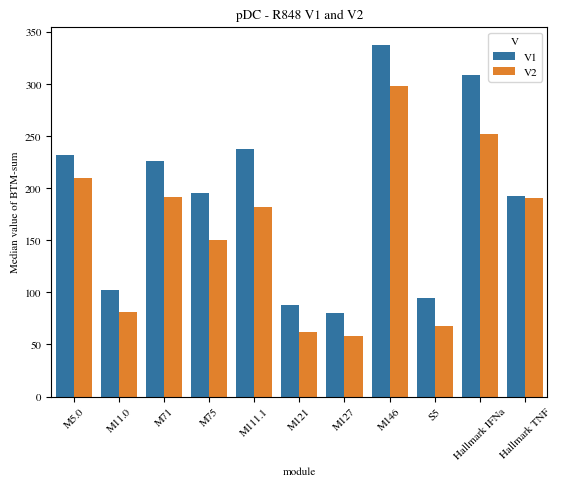

In [22]:
new_rc_params = {
"font.family": 'Times',
"font.size": 8,
"font.serif": [],
"svg.fonttype": 'none'} #to store text as text, not as path
plt.rcParams.update(new_rc_params)

sns.barplot(x = 'module', y = 'stim_values', data = barplot_df, hue = 'V')
plt.xticks(rotation = 45, )
plt.ylabel('Median value of BTM-sum')
plt.title('pDC - R848 V1 and V2')

# Extended Figure 2c - MX1

In [7]:
r8_v1 = sc.read_h5ad(r848_v1_path)
r8_v2 = sc.read_h5ad(r848_v2_path)

ct = 'pDC'
pdc_r848v1 = r8_v1[r8_v1.obs.celltype == ct].to_df() 
pdc_r848v2 = r8_v2[r8_v2.obs.celltype == ct].to_df()


In [8]:
#Divide cells into low- or highIRF7 depending on the median
lowIRF7v1 = pdc_r848v1[pdc_r848v1['IRF7'] < np.median(pdc_r848v1['IRF7'])]
highIRF7v1 = pdc_r848v1[pdc_r848v1['IRF7'] >= np.median(pdc_r848v1['IRF7'])]

lowIRF7v2 = pdc_r848v2[pdc_r848v2['IRF7'] < np.median(pdc_r848v2['IRF7'])]
highIRF7v2 = pdc_r848v2[pdc_r848v2['IRF7'] >= np.median(pdc_r848v2['IRF7'])]

In [9]:
#DataFrame formatting for the plot
highIRF7v1 = pd.DataFrame(highIRF7v1['MX1']).melt()
highIRF7v1['IRF7'] = 'high'

lowIRF7v1 = pd.DataFrame(lowIRF7v1['MX1']).melt()
lowIRF7v1['IRF7'] = 'low'

irf7v1 = pd.concat([lowIRF7v1, highIRF7v1])
irf7v1 = irf7v1.rename(columns = {'variable': 'gene'})

highIRF7v2 = pd.DataFrame(highIRF7v2['MX1']).melt()
highIRF7v2['IRF7'] = 'high'

lowIRF7v2 = pd.DataFrame(lowIRF7v2['MX1']).melt()
lowIRF7v2['IRF7'] = 'low'

irf7v2 = pd.concat([lowIRF7v2, highIRF7v2])
irf7v2 = irf7v2.rename(columns = {'variable': 'gene'})

Text(1085.0378787878785, 0.5, 'Genecount')

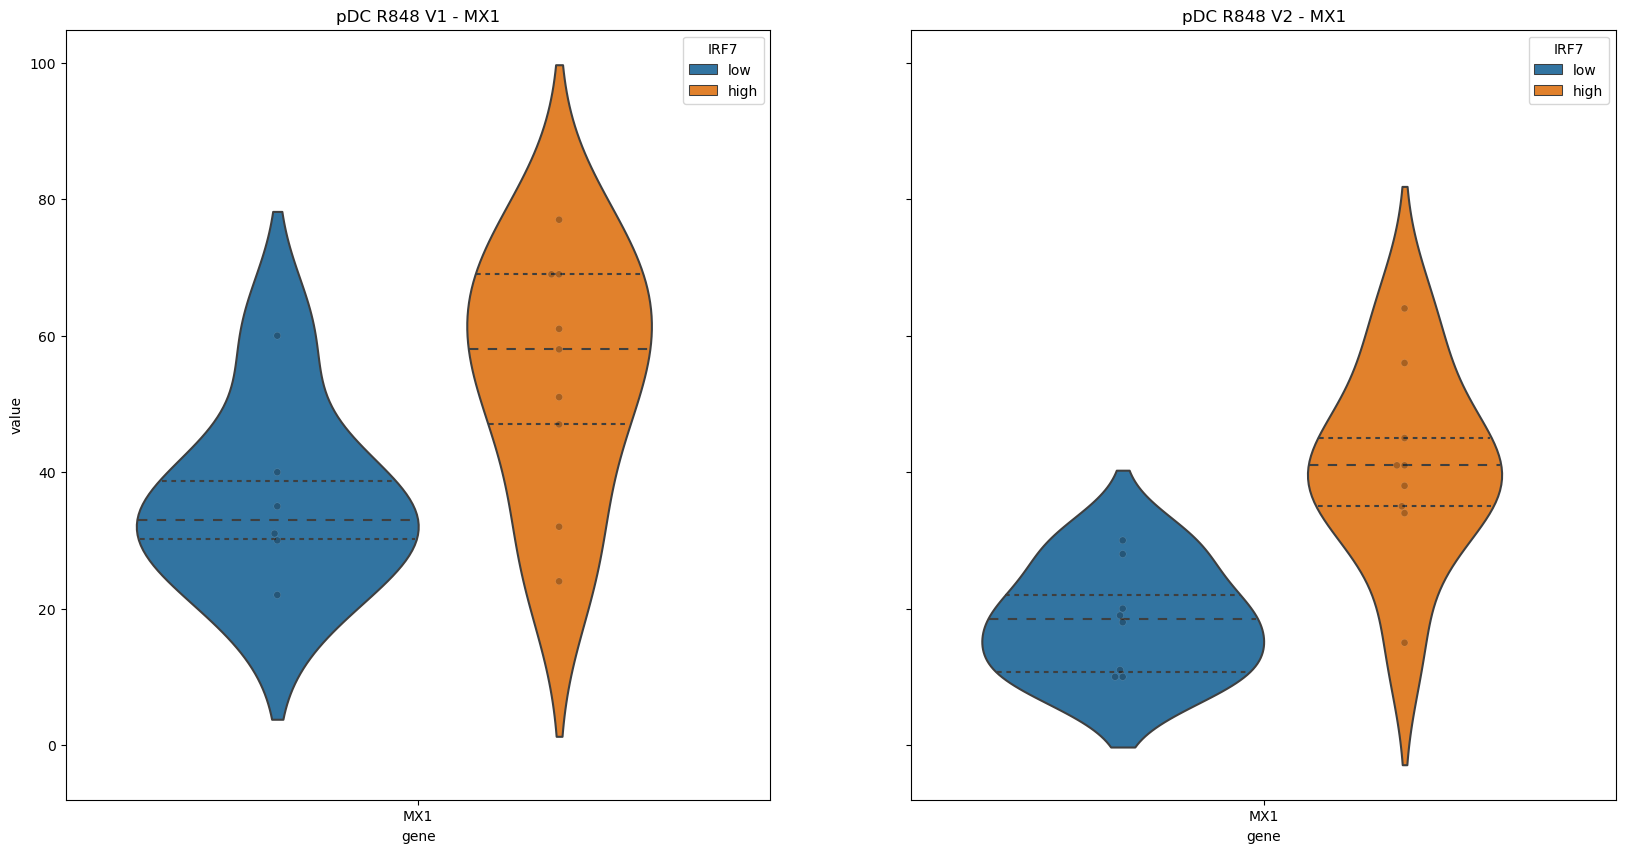

In [10]:
fig, ax = plt.subplots(1,2, figsize = (20,10), sharey = True)
sns.swarmplot(x = 'gene', y = 'value', hue = 'IRF7', data = irf7v1, dodge = True, edgecolor = 'white', linewidth = 0.25, alpha = 0.25, palette = ['black', 'black'], legend = False, ax = ax[0])
sns.violinplot(x = 'gene', y = 'value', hue = 'IRF7', data = irf7v1, inner = 'quartile', ax = ax[0])

sns.swarmplot(x = 'gene', y = 'value', hue = 'IRF7', data = irf7v2, dodge = True, edgecolor = 'white', linewidth = 0.25, alpha = 0.25, palette = ['black', 'black'], legend = False, ax = ax[1])
sns.violinplot(x = 'gene', y = 'value', hue = 'IRF7', data = irf7v2, inner = 'quartile', ax = ax[1])

ax[0].set_title('pDC R848 V1 - MX1')
ax[1].set_title('pDC R848 V2 - MX1')
plt.ylabel('Genecount')

# Extended data Figure 3c - Monocyte R848 barplot

In [11]:
r8_v1 = sc.read_h5ad(r848_v1_path)
r8_v2 = sc.read_h5ad(r848_v2_path)
ct = 'Monocyte'
stim_v1 = r8_v1[r8_v1.obs.celltype == ct].to_df() 
stim_v2 = r8_v2[r8_v2.obs.celltype == ct].to_df()


In [12]:
stim_v1 = stim_v1[stim_v1.columns[stim_v1.columns.isin(stim_v2.columns)]]
stim_v2 = stim_v2[stim_v2.columns[stim_v2.columns.isin(stim_v1.columns)]]

In [13]:
hallmark_ifna = ["CMTR1","HERC6", "IFIH1", "IFIT2", "OASL", "IRF7", "DDX60", "CNP", "RSAD2", "TMEM140", "OAS1", "PARP14", "TRIM5", "EIF2AK2", "LGALS3BP", "TRIM21", "STAT2", "PNPT1", "HELZ2", "USP18", "TXNIP", "GBP4", "RTP4", "TRAFD1", "MOV10",
                 "LY6E", "IFI35", "MX1", "ISG20", "CXCL11", "IFIT3", "SAMD9", "PARP12", "DHX58", "LPAR6", "IFITM3", "SELL", "ADAR", "TRIM25", "SP110", "NUB1", "IRF2", "GMPR", "ELF1"]


In [14]:
hallmark_tnf = ["GEM", "CCL20", "MSC", "IL23A", "CD80", "TUBB2A", "IL1A", "IL6", "FOSL1", "DUSP4", "INHBA", "PLAU", "CD83",
                "F3", "CXCL2", "EDN1", "GFPT2","TRAF1", "SOCS3", "RCAN1","ZC3H12A", "PMEPA1", "SPSB1", "GADD45B", "GADD45A", "BTG3",
                "PPP1R15A", "SERPINB2", "ID2", "BIRC3", "SOD2", "HES1", "TNFAIP6", "G0S2", "EIF1", "CD44", "MAFF", "ICAM1", "MAP3K8",
               "YRDC", "BCL2A1", "DUSP2", "PFKFB3", "LAMB3", "EFNA1", "CLCF1", "TNIP2", "ZBTB10", "EGR2", "IL1B", "MAP2K3", "NR4A2",
               "CCND1", "TNFAIP2", "TNF", "TNFAIP8", "NFKB2", "KYNU", "TNFAIP3", "BCL6", "CEBPB", "NAMPT", "SLC2A6", "CCRL2"]

In [15]:
inhouse_btms = pd.DataFrame({'ID':['Hallmark IFNa', 'Hallmark TNF'], 'Module title': 'X', 'Composite name': ['Hallmark IFNa', 'Hallmark TNF'], 'Module category':'X', 'Annotation level':'X', 'Module member genes': [', '.join(hallmark_ifna), ', '.join(hallmark_tnf)]})


In [16]:
btm = pd.read_csv('btm_annotation_table.csv', sep = ';')
btm = btm[['ID', 'Module title','Composite name', 'Module category', 'Annotation level', 'Module member genes']]

In [17]:
btm_append = btm.append(inhouse_btms)

In [18]:
btm_df_V1 = pd.DataFrame()
btm_df_V2 = pd.DataFrame()

dfs_btm = [btm_df_V1, btm_df_V2]
dfs_data = [stim_v1, stim_v2]

genes_included = pd.DataFrame(columns = ['Module', 'Genes'])

btm_file = btm_append

for i,df in enumerate(dfs_data):
    for j in range(len(btm_file)):
        markers = re.findall(r"[\w'-]+", btm_file.iloc[j, 5])
        #Take median of BTMs
        temp = pd.DataFrame({btm_file.iloc[j, 0]:np.median(np.sum(df[df.columns[df.columns.isin(markers)]], axis = 1))}, index = [0])
        genes_included = genes_included.append(pd.DataFrame({'Module': btm_file.iloc[j, 0], 'Composite Name':btm_file.iloc[j,2],'Genes': [df.columns[df.columns.isin(markers)].values]}, index=[0]))
        
        dfs_btm[i] = pd.concat([dfs_btm[i], temp], axis = 1)
genes_included = genes_included.drop_duplicates(subset = 'Module')

In [19]:
btms_v1 = dfs_btm[0].T.reset_index()
btms_v2 = dfs_btm[1].T.reset_index()

In [20]:
btms_v1.columns = ['module', 'sum']
btms_v2.columns = ['module', 'sum']

In [21]:
df_btm_v1 = pd.DataFrame({'module':btms_v1.module, 'stim_values':btms_v1['sum']})
df_btm_v2 = pd.DataFrame({'module':btms_v2.module, 'stim_values':btms_v2['sum']})

In [22]:
df_btm_v1['V'] = 'V1'
df_btm_v2['V'] = 'V2'

In [23]:
barplot_df = pd.concat([df_btm_v1, df_btm_v2])

In [24]:
modules_r848 = ['M13', 'M27.0', 'M29', 'M43.0', 'M86.1', 'M127', 'M165', 'Hallmark IFNa', 'Hallmark TNF']

barplot_df = barplot_df[barplot_df.module.isin(modules_r848)]

Text(0.5, 1.0, 'Monocyte - R848 V1 and V2')

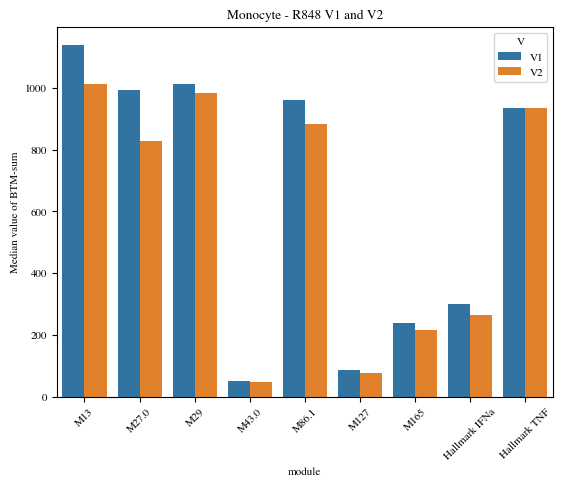

In [25]:
new_rc_params = {
"font.family": 'Times',
"font.size": 8,
"font.serif": [],
"svg.fonttype": 'none'} #to store text as text, not as path
plt.rcParams.update(new_rc_params)

sns.barplot(x = 'module', y = 'stim_values', data = barplot_df, hue = 'V')
plt.xticks(rotation = 45, )
plt.ylabel('Median value of BTM-sum')
plt.title('Monocyte - R848 V1 and V2')


# Extended Data Figure 4 c,d,e - Th1,2,17 markers

In [26]:
ntc_v1 = sc.read_h5ad(ntc_v1_path)
ntc_v2 = sc.read_h5ad(ntc_v2_path)


In [27]:
th1_markers = ['TNF',
 'IFNG',
 'EGR2',
 'CCL4L2',
 'F2R',
 'APOBEC3G',
 'FASLG',
 'IL2',
 'CCL4',
 'CCL5',
 'AOAH',
 'GZMA',
 'GZMB',
 'TBX21',
 'GZMK',
 'ALDOC']

In [28]:
th2_markers = [
 'PLIN2',
 'CD83',
 'NFKBIZ',
 'NFKBID',
 'CCR4',
 'GATA3',
 'PPARG',
 'LIF',
 'IL9R',
 'BCAR3',
 'C1orf162',
 'CHDH',
 'GPR35',
 'NENF',
 'PDLIM5',
 'PLN']

In [29]:
th17_markers = [
 'ABCB1',
 'THBS1',
 'TRBV18',
 'TRAV13-2',
 'PTPN22',
 'RUNX2',
 'IL18RAP',
 'IL23R',
 'GPR65',
 'MGAT4A',
 'TMIGD2']

In [30]:
cd4t_v1 = ntc_v1[ntc_v1.obs.celltype == 'CD4T'].copy().to_df()
cd4t_v2 = ntc_v2[ntc_v2.obs.celltype == 'CD4T'].copy().to_df()

In [31]:
markers = th1_markers
v1 = pd.melt(cd4t_v1[markers])
v2 = pd.melt(cd4t_v2[markers])
v1['V'] = 'V1'
v2['V'] = 'V2'
th1_df = pd.concat([v1,v2])

markers = th2_markers
v1 = pd.melt(cd4t_v1[markers])
v2 = pd.melt(cd4t_v2[markers])
v1['V'] = 'V1'
v2['V'] = 'V2'
th2_df = pd.concat([v1,v2])

markers = th17_markers
v1 = pd.melt(cd4t_v1[markers])
v2 = pd.melt(cd4t_v2[markers])
v1['V'] = 'V1'
v2['V'] = 'V2'
th17_df = pd.concat([v1,v2])


Text(0.5, 63.0972222222222, '')

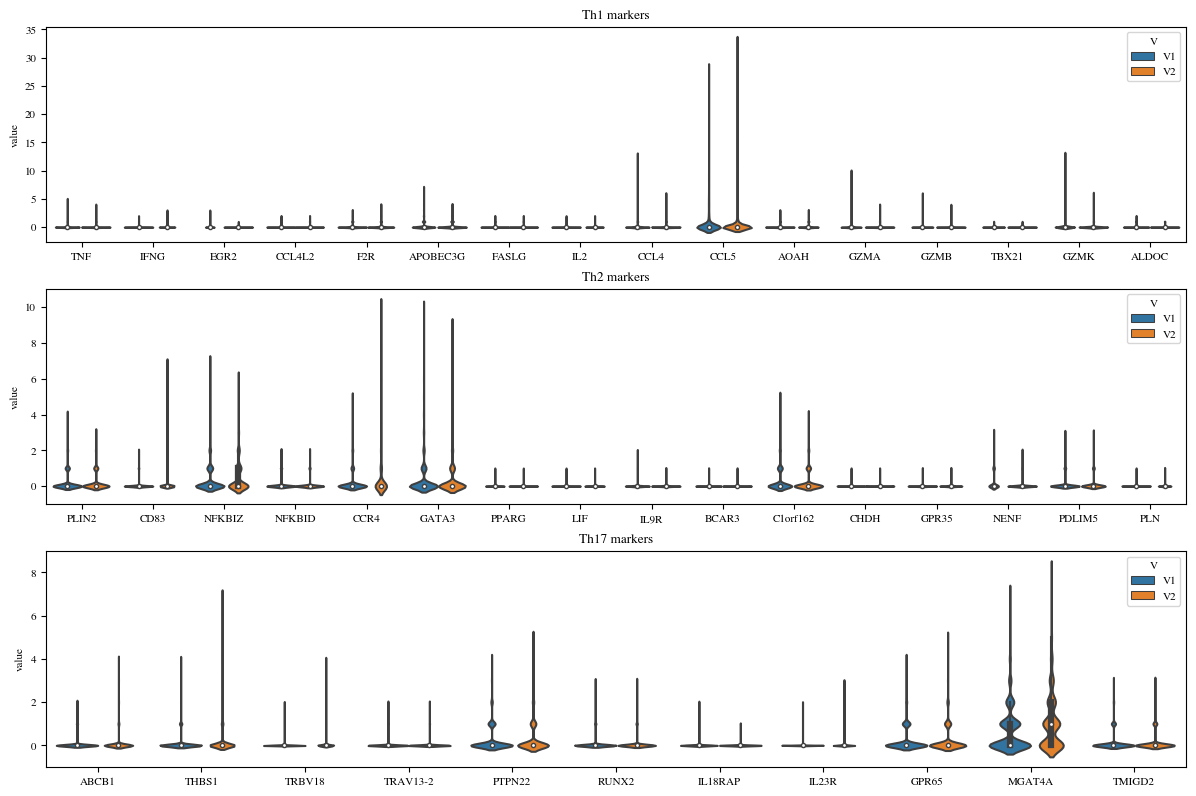

In [33]:
fig, ax = plt.subplots(3,1, figsize = (12,8))
sns.violinplot(data = th1_df, x = 'variable', y = 'value', hue = 'V', ax = ax[0])
sns.violinplot(data = th2_df, x = 'variable', y = 'value', hue = 'V', ax = ax[1])
sns.violinplot(data = th17_df, x = 'variable', y = 'value', hue = 'V', ax = ax[2])

plt.tight_layout()
ax[0].set_title('Th1 markers')
ax[1].set_title('Th2 markers')
ax[2].set_title('Th17 markers')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')
